In [2]:
import os
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainspace.plotting import plot_hemispheres, surface_plotting
from brainspace.mesh.mesh_io import convert_surface, read_surface
from brainstat.tutorial.utils import fetch_mics_data
from brainspace import plotting, datasets
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
from IPython.display import display, Image
import matplotlib.pyplot as plt
from scipy import stats 
#from mayavi import mlab
import brainstat as bs
import nibabel as nib
import pandas as pd
#%matplotlib inline
import numpy as np 
import brainspace
#import subprocess
from scipy.stats import zscore

In [3]:
df = pd.read_excel("/home/ishaq/Downloads/Tableurs/Liste_finale_des_participants_gardés.xlsx")
df_glasser = pd.read_excel("/home/ishaq/Downloads/Tableurs/df_glasser360.xlsx")
df_schaefer = pd.read_excel("/home/ishaq/Downloads/Tableurs/df_schaeffer.xlsx")
participants = pd.read_csv("/home/ishaq/Downloads/Tableurs/participants_gardes.tsv")

In [4]:
df

Unnamed: 0 participant_id  SUBJID INIT_NOM INIT_PRENOM  AGE SEXE  \
0             0       01002KAP    1002        K           A   68    M   
1             1       01005AGP    1005        A           G   51    M   
2             2       01006SCP    1006        S           C   55    M   
3             3       01007LAP    1007        L           A   63    F   
4             4       01008LBP    1008        L           B   53    F   
..          ...            ...     ...      ...         ...  ...  ...   
186         186       19035SPP   19035        S           P   59    M   
187         187       19036CJP   19036        C           J   73    F   
188         188       19037GHP   19037        G           H   65    M   
189         189       19038HGP   19038        H           G   53    F   
190         190       19042DJP   19042        D           J   67    M   

             SITE_APP  RILU  SIT_BUL_CENT  ...    V0  Diff_inclusion_PS  \
0            Bulbaire   1.0           1.0  ...  34.0               11.0   
1    Membre inférieur   1.0           0.0  ...  43.0               14.0   
2    Membre inférieur   1.0           0.0  ...  46.0               18.0   
3    Membre inférieur   1.0           0.0  ...  39.0               13.0   
4            Bulbaire   1.0           1.0  ...  29.0               19.0   
..                ...   ...           ...  ...   ...                ...   
186  Membre supérieur   0.0           1.0  ...  41.0               21.0   
187  Membre inférieur   1.0           0.0  ...  39.0               23.0   
188  Membre inférieur   0.0           0.0  ...  43.0               12.0   
189  Membre inférieur   0.0           0.0  ...  41.0               60.0   
190  Membre supérieur   1.0           0.0  ...  33.0                7.0   

     Score_de_declinaison  Declin  Centre  LATERALITE  SCORE_TM   FORM_FAM  \
0                0.551433    Slow   Lille    Droitier      88.0        Non   
1                0.316186    Slow   Lille    Droitier     106.0        Non   
2                0.088537    Slow   Lille    Droitier     106.0        Non   
3                0.741379    Fast   Lille    Droitier       0.0        Oui   
4                1.018623    Fast   Lille    Droitier      79.0  Suspicion   
..                    ...     ...     ...         ...       ...        ...   
186              0.333333    Slow  Angers    Droitier      94.0        Non   
187              0.681200    Fast  Angers    Droitier      81.0        Non   
188              0.183707    Slow  Angers    Droitier     107.0        Non   
189              0.116667    Slow  Angers    Droitier     100.0        Non   
190              2.048964    Fast  Angers         NaN       NaN        Non   

     SUBJECT_GROUP  DFT  
0             Case  NaN  
1             Case  NaN  
2             Case  NaN  
3             Case  Oui  
4             Case  NaN  
..             ...  ...  
186           Case  NaN  
187           Case  NaN  
188           Case  NaN  
189           Case  NaN  
190           Case  NaN  

[191 rows x 27 columns]

In [5]:
participants_ecartes = ["15002OJP", "15003FMP", "15004CAP"]

for index, row in df.iterrows():
    if row["participant_id"] in participants_ecartes : 
        df= df.drop(index)
df = df.reset_index(drop=True)

In [6]:
df_identifiant = df_glasser["SUBJID"]

In [7]:
mask = fetch_mask("fsaverage5")
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)


In [8]:
#Division en fonction de la latéralité
glasser_right = df_glasser.filter(like="Right")
glasser_left = df_glasser.filter(like = "Left")
schaefer_right = df_schaefer.filter(like="Right")
schaefer_left = df_schaefer.filter(like = "Left")

#DataFrame avec uniquement les moyennes 
schaefer_moyenne_right = schaefer_right.filter(like="Moyenne")
schaefer_moyenne_left = schaefer_left.filter(like="Moyenne")
glasser_moyenne_right = glasser_right.filter(like="Moyenne")
glasser_moyenne_left = glasser_left.filter(like="Moyenne")

#DataFrame avec uniquement les variances 
schaefer_variance_right = schaefer_right.filter(like="Variance")
schaefer_variance_left = schaefer_left.filter(like="Variance")
glasser_variance_right = glasser_right.filter(like="Variance")
glasser_variance_left = glasser_left.filter(like="Variance")

#DataFrame avec uniquement les Q1 
schaefer_Q1_right = schaefer_right.filter(like="Q1")
schaefer_Q1_left = schaefer_left.filter(like="Q1")
glasser_Q1_right = glasser_right.filter(like="Q1")
glasser_Q1_left = glasser_left.filter(like="Q1")

#DataFrame avec uniquement les Q3
schaefer_Q3_right = schaefer_right.filter(like="Q3")
schaefer_Q3_left = schaefer_left.filter(like="Q3")
glasser_Q3_right = glasser_right.filter(like="Q3")
glasser_Q3_left = glasser_left.filter(like="Q3")

In [9]:
#Liste des fichiers R2
participants_rapides = []
participants_lents = []
participants_R2 = []

for index, row in df.iterrows():
    participants_R2.append("/NAS/tupac/protocoles/PULSE/MNI152/sub-{row['participant_id']}_R2_in_space-MNI152_0.8mm.nii.gz")
    if row["Declin"] == "Slow" : 
        participants_rapides.append(row['participant_id'])
    if row["Declin"] == "Fast" : 
        participants_rapides.append(row['participant_id'])

In [42]:
#Affichage de la surface R2 pour tous les participants 

pial_left , pial_right = fetch_template_surface("fsaverage5", join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
thickness, demographics = fetch_mics_data()

#Création d'un array à deux dimensions (utile pour le SLM)
array_test = np.arange(40968)
R2 = array_test.reshape(2,-1)

for index, row in participants.iterrows():
    if row[0] == "15001GCP" or row[0] == "15003FMP" or row[0] == "15004CAP":
        continue
    R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row[0]}_L_projection.func.gii")
    R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row[0]}_R_projection.func.gii")

    R2_tot=np.concatenate([R2_l.agg_data(),R2_r.agg_data()],axis=0)
    R2 = np.vstack([R2,R2_tot])
     
#    plot_hemispheres(pial_left, pial_right,R2_tot, color_bar = True, color_range=(20,100), 
#                        label_text=[f"R2 {row[0]}"], cmap = "viridis", embed_nb=False, size=(1400,200), 
#                         zoom=1.45,
#                         nan_color=(0.7,0.7,0.7,1), screenshot = True, filename = f"/home/ishaq/Downloads/plot_hemisphere/{row[0]}.png" ,
#                         cb__labelTextProperty={"fontSize": 12}, interactive = True,transparent_bg=False)
#    display(Image(filename=f"/home/ishaq/Downloads/plot_hemisphere/{row[0]}.png"))
#R2 = R2[2:]

In [21]:
for cpt,suj in enumerate(df[df['SITE_APP']=='Membre inférieur']['SITE_APP']):
    print(cpt,suj)

0 Membre inférieur
1 Membre inférieur
2 Membre inférieur
3 Membre inférieur
4 Membre inférieur
5 Membre inférieur
6 Membre inférieur
7 Membre inférieur
8 Membre inférieur
9 Membre inférieur
10 Membre inférieur
11 Membre inférieur
12 Membre inférieur
13 Membre inférieur
14 Membre inférieur
15 Membre inférieur
16 Membre inférieur
17 Membre inférieur
18 Membre inférieur
19 Membre inférieur
20 Membre inférieur
21 Membre inférieur
22 Membre inférieur
23 Membre inférieur
24 Membre inférieur
25 Membre inférieur
26 Membre inférieur
27 Membre inférieur
28 Membre inférieur
29 Membre inférieur
30 Membre inférieur
31 Membre inférieur
32 Membre inférieur
33 Membre inférieur
34 Membre inférieur
35 Membre inférieur
36 Membre inférieur
37 Membre inférieur
38 Membre inférieur
39 Membre inférieur
40 Membre inférieur
41 Membre inférieur
42 Membre inférieur
43 Membre inférieur
44 Membre inférieur
45 Membre inférieur
46 Membre inférieur
47 Membre inférieur
48 Membre inférieur
49 Membre inférieur
50 Membre 

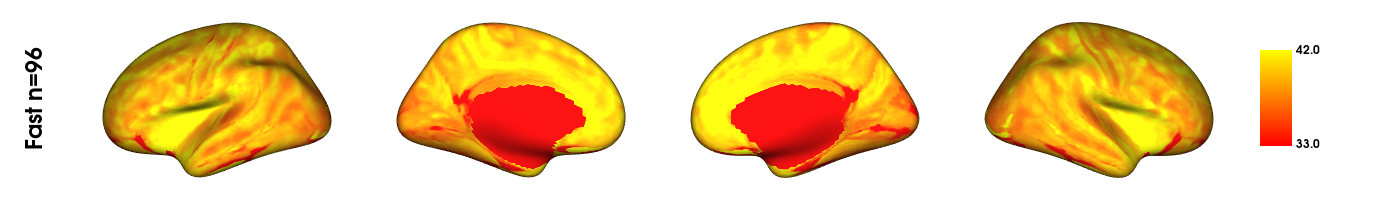

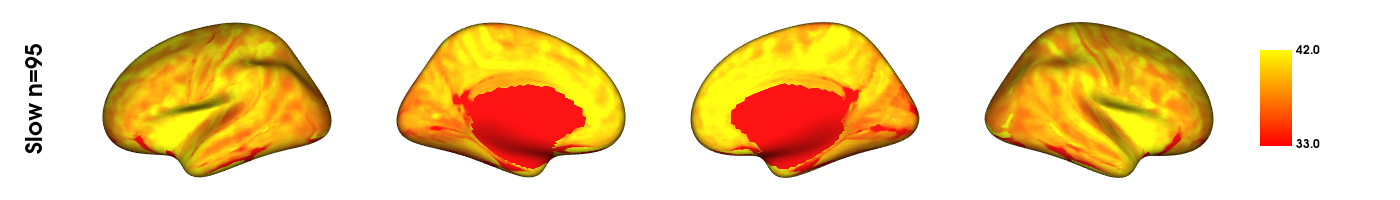

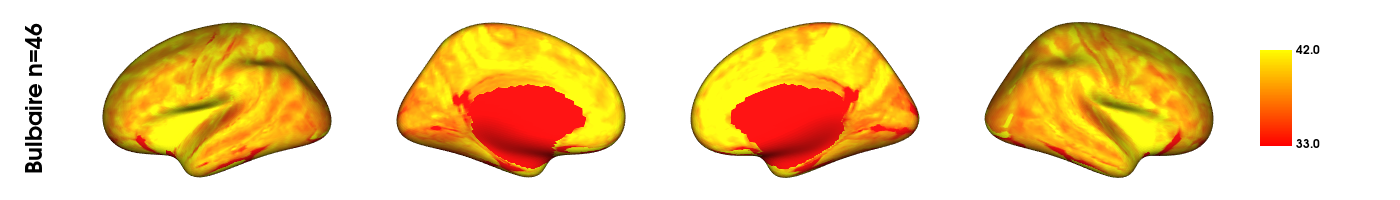

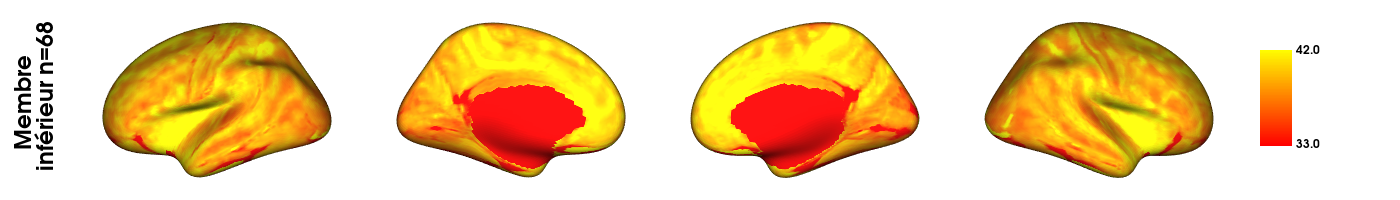

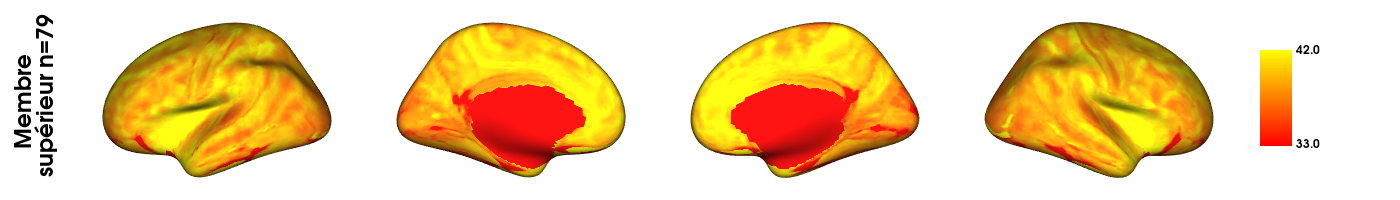

In [24]:
array_test = np.arange(40968)
R2 = array_test.reshape(2,-1)

for row in df[df['Declin']=='Fast']['participant_id'].values:
    if row == "15001GCP" or row == "15003FMP" or row == "15004CAP":
        continue
    R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_L_projection.func.gii")
    R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_R_projection.func.gii")

    R2_tot=np.concatenate([R2_l.agg_data(),R2_r.agg_data()],axis=0)
    R2 = np.vstack([R2,R2_tot])

tmp_c=np.clip(R2,np.quantile(R2,0),np.quantile(R2,0.99))
figure_title=os.path.join("/NAS","tupac","protocoles","PULSE","R2_nilearn_Fast.png")
plot_hemispheres(inflated_left, inflated_right,(1000./np.median(tmp_c,axis=0))*mask, 
                 color_bar = True, color_range=(33,42),label_text=[f"Fast n={R2.shape[0]}"], 
                 cmap = "autumn", embed_nb=True, size=(1400,200), zoom=1.45, 
                 cb__labelTextProperty={"fontSize": 12},screenshot = True, filename = figure_title,
                 interactive= False, transparent_bg = False)
display(Image(filename=figure_title))

############################
array_test = np.arange(40968)
R2 = array_test.reshape(2,-1)

for row in df[df['Declin']!='Fast']['participant_id'].values:
    if row == "15001GCP" or row == "15003FMP" or row == "15004CAP":
        continue
    R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_L_projection.func.gii")
    R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_R_projection.func.gii")

    R2_tot=np.concatenate([R2_l.agg_data(),R2_r.agg_data()],axis=0)
    R2 = np.vstack([R2,R2_tot])

tmp_c=np.clip(R2,np.quantile(R2,0),np.quantile(R2,0.99))
figure_title=os.path.join("/NAS","tupac","protocoles","PULSE","R2_nilearn_Slow.png")
plot_hemispheres(inflated_left, inflated_right,(1000./np.median(tmp_c,axis=0))*mask, 
                 color_bar = True, color_range=(33,42),label_text=[f"Slow n={R2.shape[0]}"], 
                 cmap = "autumn", embed_nb=True, size=(1400,200), zoom=1.45, 
                 cb__labelTextProperty={"fontSize": 12},screenshot = True, filename = figure_title,
                 interactive= False, transparent_bg = False)
display(Image(filename=figure_title))

############################
array_test = np.arange(40968)
R2 = array_test.reshape(2,-1)
for row in df[df['SITE_APP']=='Bulbaire']['participant_id'].values:
    if row == "15001GCP" or row == "15003FMP" or row == "15004CAP":
        continue
    R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_L_projection.func.gii")
    R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_R_projection.func.gii")

    R2_tot=np.concatenate([R2_l.agg_data(),R2_r.agg_data()],axis=0)
    R2 = np.vstack([R2,R2_tot])

tmp_c=np.clip(R2,np.quantile(R2,0),np.quantile(R2,0.99))
figure_title=os.path.join("/NAS","tupac","protocoles","PULSE","R2_nilearn_Bulbaire.png")
plot_hemispheres(inflated_left, inflated_right,(1000./np.median(tmp_c,axis=0))*mask, 
                 color_bar = True, color_range=(33,42),label_text=[f"Bulbaire n={R2.shape[0]}"], 
                 cmap = "autumn", embed_nb=True, size=(1400,200), zoom=1.45, 
                 cb__labelTextProperty={"fontSize": 12},screenshot = True, filename = figure_title,
                 interactive= False, transparent_bg = False)
display(Image(filename=figure_title))

############################
array_test = np.arange(40968)
R2 = array_test.reshape(2,-1)
for row in df[df['SITE_APP']=='Membre inférieur']['participant_id'].values:
    if row == "15001GCP" or row == "15003FMP" or row == "15004CAP":
        continue
    R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_L_projection.func.gii")
    R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_R_projection.func.gii")

    R2_tot=np.concatenate([R2_l.agg_data(),R2_r.agg_data()],axis=0)
    R2 = np.vstack([R2,R2_tot])

tmp_c=np.clip(R2,np.quantile(R2,0),np.quantile(R2,0.99))
figure_title=os.path.join("/NAS","tupac","protocoles","PULSE","R2_nilearn_Membre_inf.png")
plot_hemispheres(inflated_left, inflated_right,(1000./np.median(tmp_c,axis=0))*mask, 
                 color_bar = True, color_range=(33,42),label_text=[f"Membre \n inférieur n={R2.shape[0]}"], 
                 cmap = "autumn", embed_nb=True, size=(1400,200), zoom=1.45, 
                 cb__labelTextProperty={"fontSize": 12},screenshot = True, filename = figure_title,
                 interactive= False, transparent_bg = False)
display(Image(filename=figure_title))

#############################
array_test = np.arange(40968)
R2 = array_test.reshape(2,-1)
for row in df[df['SITE_APP']=='Membre supérieur']['participant_id'].values:
    if row == "15001GCP" or row == "15003FMP" or row == "15004CAP":
        continue
    R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_L_projection.func.gii")
    R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_R_projection.func.gii")

    R2_tot=np.concatenate([R2_l.agg_data(),R2_r.agg_data()],axis=0)
    R2 = np.vstack([R2,R2_tot])

tmp_c=np.clip(R2,np.quantile(R2,0),np.quantile(R2,0.99))
figure_title=os.path.join("/NAS","tupac","protocoles","PULSE","R2_nilearn_Membre_sup.png")
plot_hemispheres(inflated_left, inflated_right,(1000./np.median(tmp_c,axis=0))*mask, 
                 color_bar = True, color_range=(33,42),label_text=[f"Membre \n supérieur n={R2.shape[0]}"], 
                 cmap = "autumn", embed_nb=True, size=(1400,200), zoom=1.45, 
                 cb__labelTextProperty={"fontSize": 12},screenshot=True, filename = figure_title,
                 interactive= False, transparent_bg = False)
display(Image(filename=figure_title))

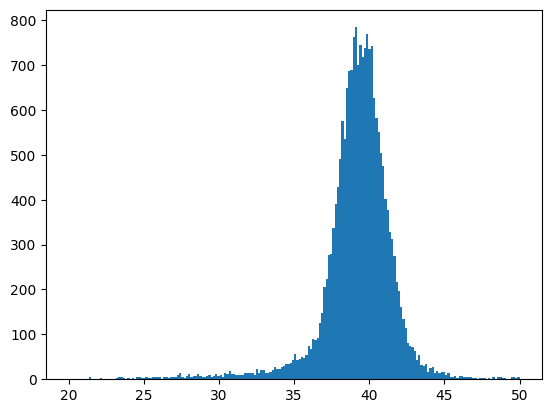

In [122]:
%matplotlib inline
__=plt.hist((1000./np.median(tmp_c,axis=0)).ravel(),200,range=[20,50])
plt.show()

In [117]:
1000./np.median(tmp_c,axis=0)

array([39.03285204, 39.20848206, 39.29981022, ..., 90.70527735,
       54.40378525, 23.84315095])

# Lissage

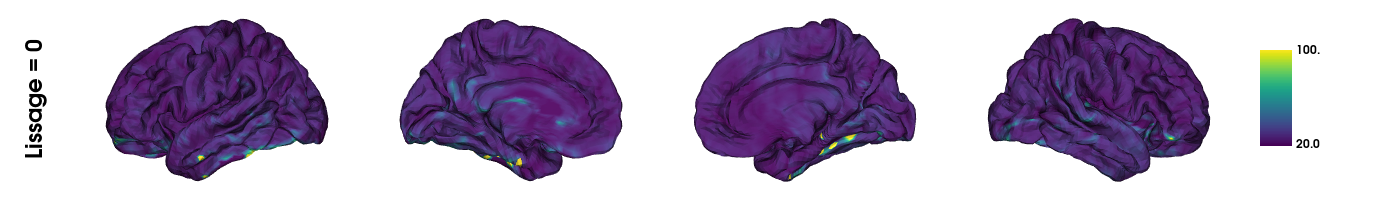

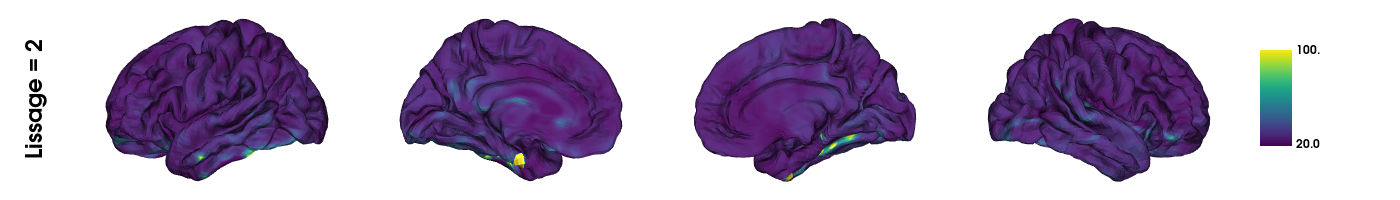

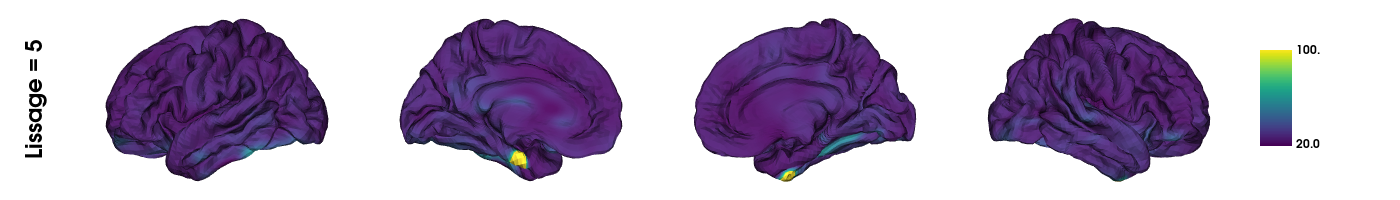

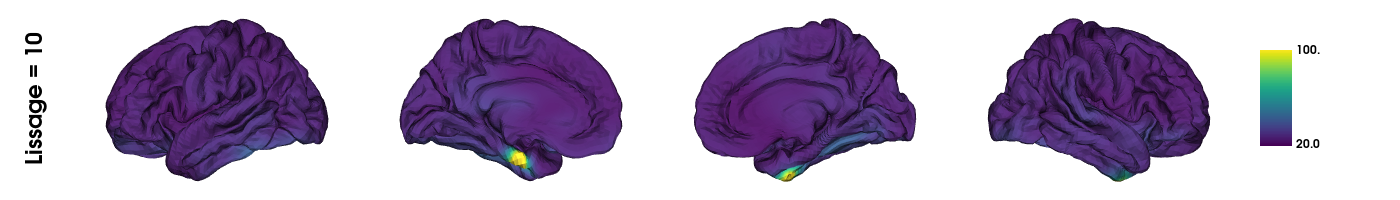

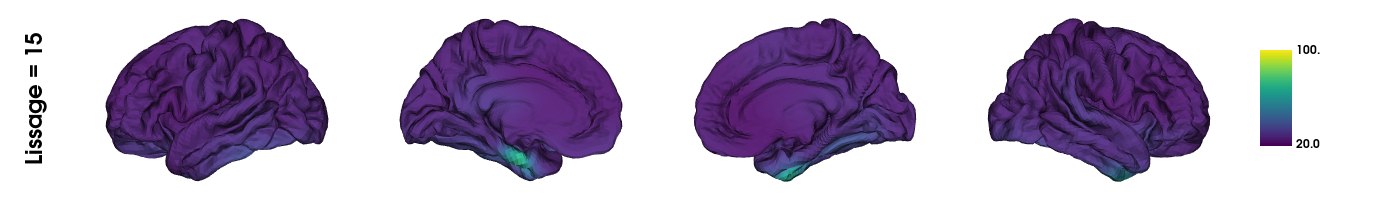

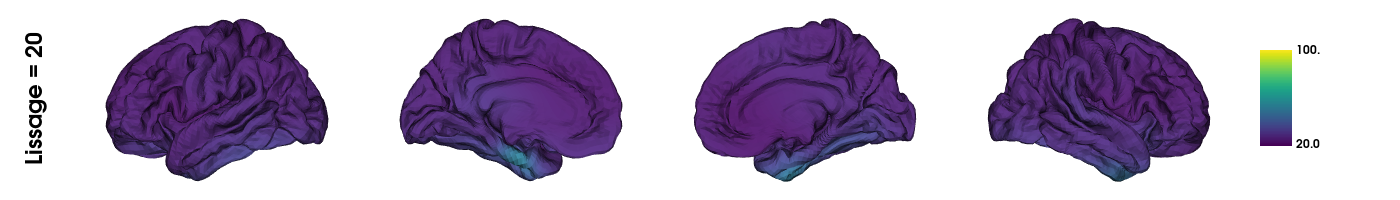

In [31]:
#Affichage de la surface R2 pour tous les degrés de lissage

liste = [".func.gii","_sm2.func.gii","_sm5.func.gii","_sm10.func.gii","_sm15.func.gii","_sm20.func.gii"]
liste_nom = ["Lissage = 0", "Lissage = 2", "Lissage = 5", "Lissage = 10", "Lissage = 15", "Lissage = 20"]
index = 0
for i in liste : 
    R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-01002KAP_L_projection{i}")
    R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-01002KAP_L_projection{i}")
    
    R2_tot = np.concatenate([R2_l.agg_data(), R2_r.agg_data()],axis=0)
    R2_tot.shape
    
    plot_hemispheres(pial_left, pial_right, R2_tot, color_bar = True, color_range=(20,100), label_text=[liste_nom[index]], cmap = "viridis", embed_nb=True, size=(1400,200), zoom=1.45, nan_color = (0.7,0.7,0.7,1), cb__labelTextProperty={"fontSize": 12},screenshot = True, filename = f"/home/ishaq/Downloads/plot_hemisphere/projection{i}.png", interactive= False, transparent_bg = False)
    
    display(Image(filename=f"/home/ishaq/Downloads/plot_hemisphere/projection{i}.png"))
    index += 1

### Exemple de l'âge

In [32]:
term_age = FixedEffect(df.AGE)
model = term_age

In [33]:
#SLM
contrast_age = df.AGE


slm_age = SLM(
    model,
    contrast_age, 
    surf= "fsaverage5",
    mask=mask,
    correction = {"fdr", "rft"},
    cluster_threshold = 0.01,
)
slm_age.fit(R2)

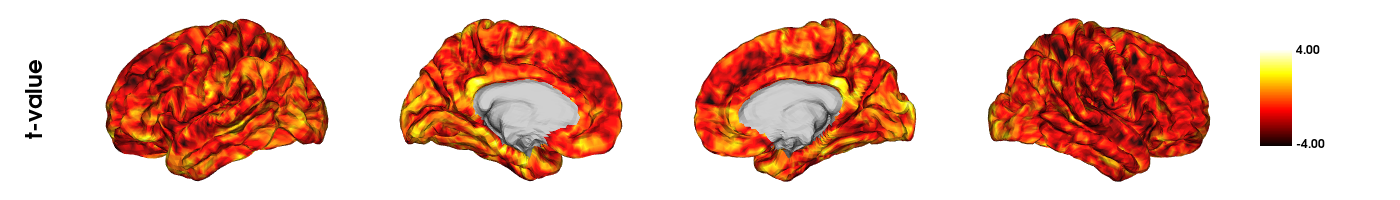

In [34]:
plot_hemispheres(pial_left, pial_right, slm_age.t, color_bar=True, color_range=(-4,4), label_text=["t-value"], cmap = "hot", embed_nb=True, size = (1400, 200), zoom=1.45, nan_color = (0.7,0.7,0.7,1), cb__labelTextProperty={"fontSize":12}, interactive=False, transparent_bg=False)

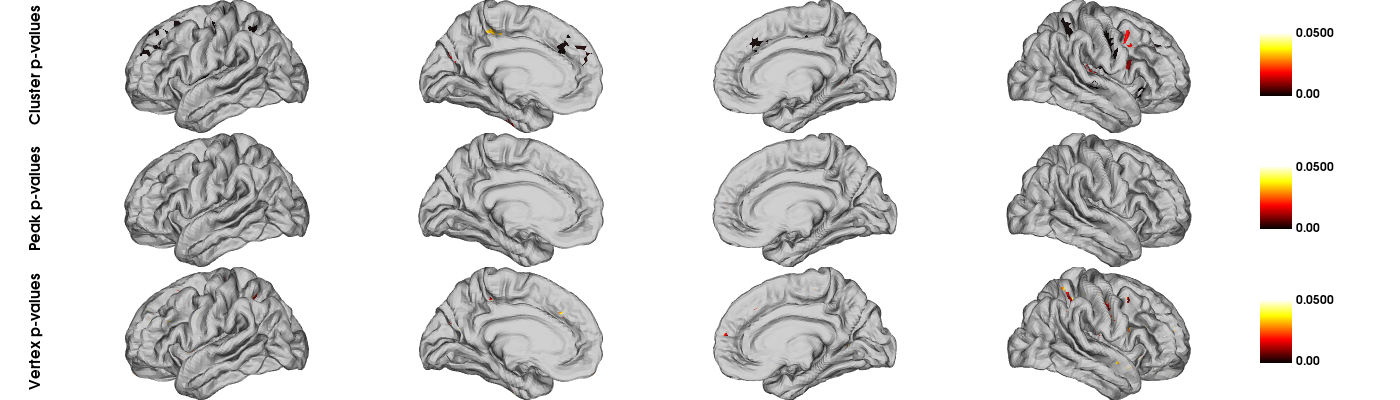

In [35]:
cp = [np.copy(slm_age.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

pp = [np.copy(slm_age.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]

qp = [np.copy(slm_age.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]

vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])

plot_hemispheres(pial_left, pial_right, vals, color_bar= True, color_range = (0, 0.05), label_text = ["Cluster p-values","Peak p-values", "Vertex p-values"], cmap="hot", embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7,0.7,0.7,1), cb__labelTextProperty={"fontSize":12}, transparent_bg = False, interactive=False)

In [36]:
print(slm_age.P["clus"][1])
print(slm_age.P["peak"][1])

     clusid  nverts     resels         P
0         1   176.0  36.175224  0.000009
1         2   138.0  32.549676  0.000009
2         3   130.0  23.993630  0.000009
3         4    71.0  10.208383  0.000009
4         5    60.0   8.224084  0.000010
..      ...     ...        ...       ...
409     410     1.0   0.087425  1.000000
410     411     1.0   0.085270  1.000000
411     412     1.0   0.084936  1.000000
412     413     1.0   0.084209  1.000000
413     414     1.0   0.055697  1.000000

[414 rows x 4 columns]
            t  vertid  clusid           P               yeo7
0    5.315025    1479       2    0.002857  Ventral Attention
1    5.201972   10748       1    0.004857  Ventral Attention
2    5.176739   10739      25    0.005489     Frontoparietal
3    5.026317    2079      14    0.010996   Dorsal Attention
4    4.996869   11871      56    0.012607     Frontoparietal
..        ...     ...     ...         ...                ...
670  2.356231   19340     234  115.809562        Somatomo

# Comparaison Fast-Slow

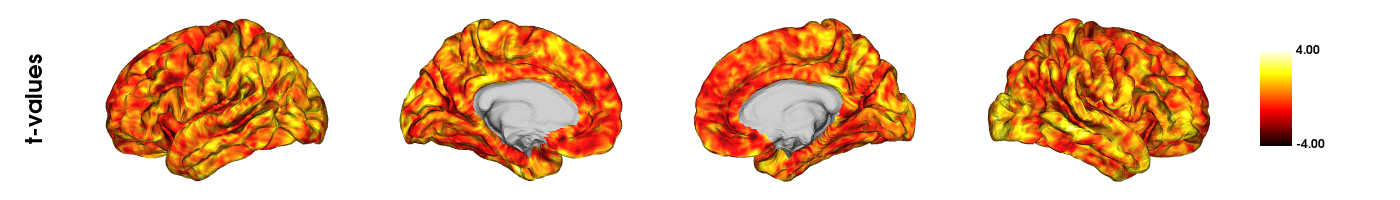

In [37]:
term_declin = FixedEffect(df.Declin)
model_declin = term_declin
contrast_declin = (df.Declin == "Fast").astype(int) - (df.Declin == "Slow").astype(int)

slm_declin = SLM(
    model_declin,
    contrast_declin,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed = False,
    cluster_threshold = 0.01,
)
slm_declin.fit(R2)

plot_hemispheres(pial_left, pial_right, slm_declin.t, color_bar = True, color_range = (-4,4), label_text = ["t-values"], cmap="hot", embed_nb=True, size=(1400,200), zoom=1.45, nan_color=(0.7,0.7,0.7,1), cb__labelTextProperty={"fontSize": 12}, transparent_bg=False, interactive=False)



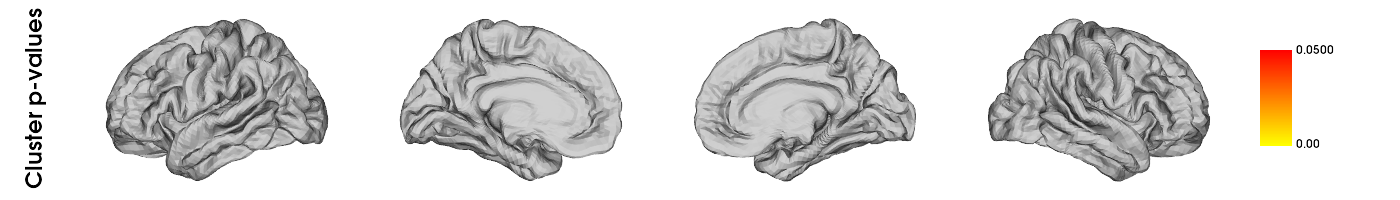

In [38]:
cp = [np.copy(slm_declin.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False)


In [39]:
print(slm_declin.P["clus"][0])

    clusid  nverts    resels         P
0        1     4.0  1.811197  0.586790
1        2     4.0  1.554344  0.819716
2        3     5.0  1.045520  0.998545
3        4     6.0  1.044189  0.998578
4        5     4.0  0.885612  0.999956
..     ...     ...       ...       ...
79      80     1.0  0.124089  1.000000
80      81     1.0  0.119111  1.000000
81      82     1.0  0.109553  1.000000
82      83     1.0  0.090220  1.000000
83      84     1.0  0.074287  1.000000

[84 rows x 4 columns]


# Spinal/Bulbaire

## Membre supérieur/Bulbaire

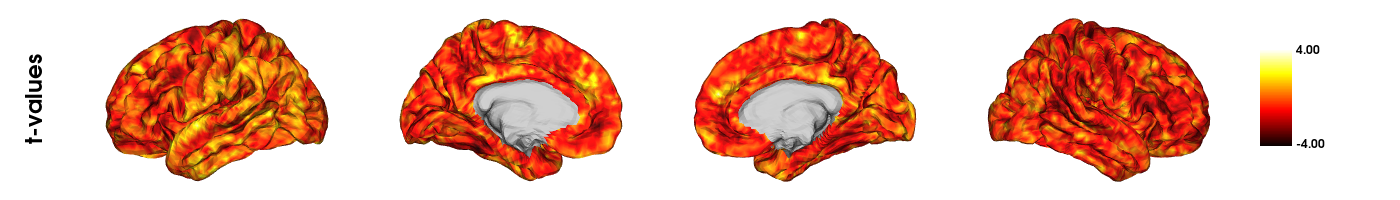

In [40]:
#DataFrame sans membre inférieur
index_supp = []
df_sansMI = pd.DataFrame()
for index, row in df.iterrows():
    if row["SITE_APP"] == "Membre inférieur":
        index_supp.append(index)
df_sansMI = df.drop(index_supp)

#Comparaison Bulbaire/Membre Supérieur 
term_atteinteBS = FixedEffect(df_sansMI.SITE_APP)
model_atteinteBS = term_atteinteBS
contraste_atteinteBS = (df_sansMI.SITE_APP == "Bulbaire").astype(int) - (df_sansMI.SITE_APP == "Membre supérieur").astype(int)

slm_atteinteBS = SLM(
    model_atteinteBS,
    contraste_atteinteBS,
    surf = pial_combined,
    mask = mask, 
    correction=["fdr",'rft'],
    two_tailed=True,
    cluster_threshold = 0.01
)

#R2 sans MI
index_supp = []
for index, row in df.iterrows(): 
    if row["SITE_APP"] == "Membre inférieur":
        index_supp.append(index)
R2_sansMI = np.delete(R2, index_supp, axis=0)
slm_atteinteBS.fit(R2_sansMI)

#Plot Hemisphere
plot_hemispheres(pial_left, pial_right, slm_atteinteBS.t, color_bar=True, color_range=(-4,4),label_text=["t-values"], cmap = "hot", embed_nb = True, size=(1400,200), zoom=1.45, nan_color=(0.7,0.7,0.7,1), cb__labelTextProperty={"fontSize":12}, interactive=False, transparent_bg=False)

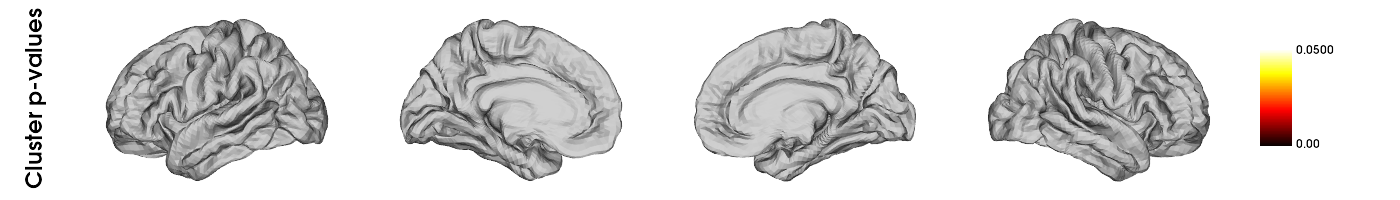

In [41]:
cp = [np.copy(slm_atteinteBS.P["pval"]["C"])]
[np.place(x, np.logical_or(x>0.05, ~mask),np.nan) for x in cp]

plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar = True, color_range=(0,0.05), label_text=["Cluster p-values"], cmap="hot", embed_nb=True, size=(1400, 200),zoom=1.45, nan_color=(0.7,0.7,0.7,1),cb__labelTextProperty={"fontSize":12}, interactive=False)

In [42]:
print(slm_atteinteBS.P["clus"][1])

     clusid  nverts    resels         P
0         1    50.0  5.343554  0.000386
1         2    10.0  2.457314  0.171626
2         3    12.0  2.242666  0.269276
3         4     7.0  1.896248  0.516856
4         5    10.0  1.622199  0.762432
..      ...     ...       ...       ...
205     206     1.0  0.117528  1.000000
206     207     1.0  0.115227  1.000000
207     208     1.0  0.113349  1.000000
208     209     2.0  0.112973  1.000000
209     210     1.0  0.110090  1.000000

[210 rows x 4 columns]


## Membre inférieur/Bulbaire

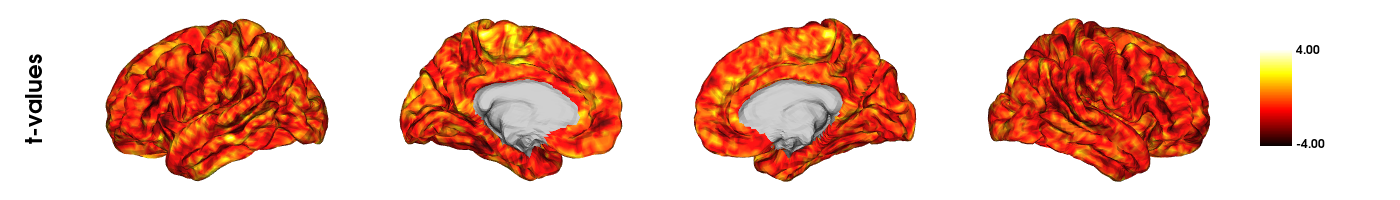

In [43]:
#DataFrame sans membre inférieur
index_supp = []
df_sansMS = pd.DataFrame()
for index, row in df.iterrows():
    if row["SITE_APP"] == "Membre supérieur":
        index_supp.append(index)
df_sansMS = df.drop(index_supp)

#Comparaison Bulbaire/Membre Supérieur 
term_atteinteBI = FixedEffect(df_sansMS.SITE_APP)
model_atteinteBI = term_atteinteBI
contraste_atteinteBI = (df_sansMS.SITE_APP == "Bulbaire").astype(int) - (df_sansMS.SITE_APP == "Membre inférieur").astype(int)

slm_atteinteBI = SLM(
    model_atteinteBI,
    contraste_atteinteBI,
    surf = pial_combined,
    mask = mask, 
    correction=["fdr",'rft'],
    two_tailed=True,
    cluster_threshold = 0.01
    )

#R2 sans MI
index_supp = []
for index, row in df.iterrows(): 
    if row["SITE_APP"] == "Membre supérieur":
        index_supp.append(index)
R2_sansMS = np.delete(R2, index_supp, axis=0)
slm_atteinteBI.fit(R2_sansMS)

#Plot Hemisphere
plot_hemispheres(pial_left, pial_right, slm_atteinteBI.t, color_bar=True, color_range=(-4,4),label_text=["t-values"], cmap = "hot", embed_nb = True, size=(1400,200), zoom=1.45, nan_color=(0.7,0.7,0.7,1), cb__labelTextProperty={"fontSize":12}, interactive=False, transparent_bg=False)

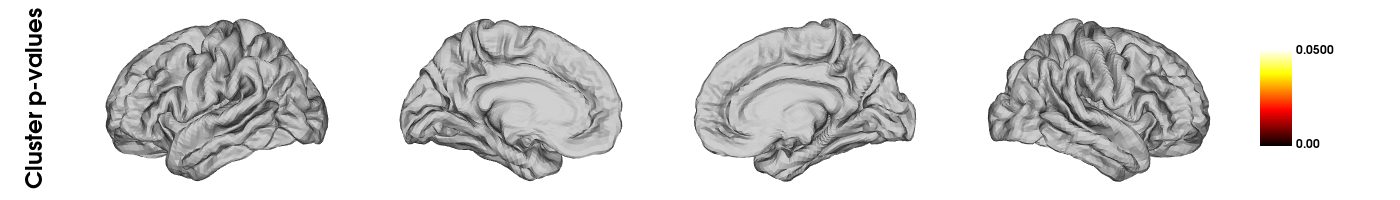

In [44]:
cp = [np.copy(slm_atteinteBI.P["pval"]["C"])]
[np.place(x, np.logical_or(x>0.05, ~mask),np.nan) for x in cp]

plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar = True, color_range=(0,0.05), transparent_bg=False, label_text=["Cluster p-values"], cmap="hot", embed_nb=True, size=(1400, 200),zoom=1.45, nan_color=(0.7,0.7,0.7,1),cb__labelTextProperty={"fontSize":12}, interactive=False)

In [45]:
print(slm_atteinteBI.P["peak"][1])

            t  vertid  clusid           P
0    4.027413    2450      85    0.982014
1    4.013741   12183       1    1.032898
2    3.977356     695       5    1.181052
3    3.749895   13453       1    2.676863
4    3.688595    8598       4    3.314139
..        ...     ...     ...         ...
295  2.365364    6354     198  120.094172
296  2.364809    8693     243  120.216153
297  2.363465    1627     224  120.511820
298  2.363283    9367     152  120.551701
299  2.361812   10991      75  120.875255

[300 rows x 4 columns]


## Membre supérieur / inférieur

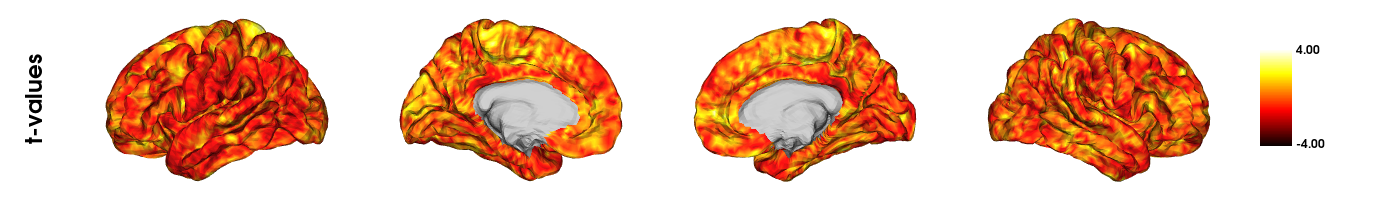

In [46]:
#DataFrame sans membre inférieur
index_supp = []
df_sansB = pd.DataFrame()
for index, row in df.iterrows():
    if row["SITE_APP"] == "Bulbaire":
        index_supp.append(index)
df_sansB = df.drop(index_supp)

#Comparaison Bulbaire/Membre Supérieur 
term_atteinteSI = FixedEffect(df_sansB.SITE_APP)
model_atteinteSI = term_atteinteSI
contraste_atteinteSI = (df_sansB.SITE_APP == "Membre supérieur").astype(int) - (df_sansB.SITE_APP == "Membre inférieur").astype(int)

slm_atteinteSI = SLM(
    model_atteinteSI,
    contraste_atteinteSI,
    surf = pial_combined,
    mask = mask, 
    correction=["fdr",'rft'],
    two_tailed=True,
    cluster_threshold = 0.01
    )

#R2 sans MI
index_supp = []
for index, row in df.iterrows(): 
    if row["SITE_APP"] == "Bulbaire":
        index_supp.append(index)
R2_sansB = np.delete(R2, index_supp, axis=0)
slm_atteinteSI.fit(R2_sansB)

#Plot Hemisphere
plot_hemispheres(pial_left, pial_right, slm_atteinteSI.t, color_bar=True, color_range=(-4,4),label_text=["t-values"], cmap = "hot", embed_nb = True, size=(1400,200), zoom=1.45, nan_color=(0.7,0.7,0.7,1), cb__labelTextProperty={"fontSize":12}, interactive=False, transparent_bg=False)

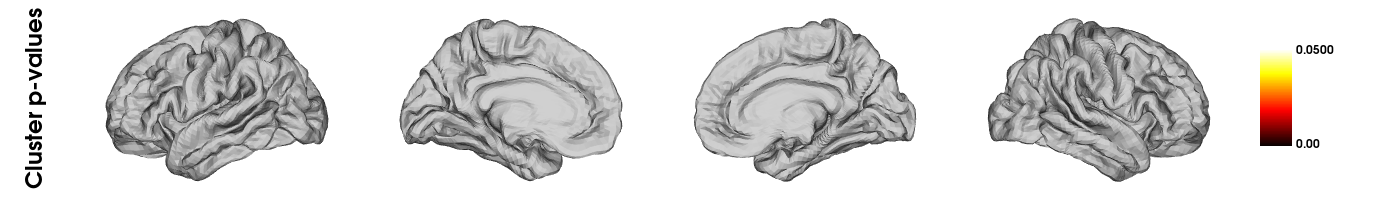

In [47]:
cp = [np.copy(slm_atteinteSI.P["pval"]["C"])]
[np.place(x, np.logical_or(x>0.05, ~mask),np.nan) for x in cp]

plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar = True, color_range=(0,0.05), transparent_bg=False, label_text=["Cluster p-values"], cmap="hot", embed_nb=True, size=(1400, 200),zoom=1.45, nan_color=(0.7,0.7,0.7,1),cb__labelTextProperty={"fontSize":12}, interactive=False)

In [48]:
diff = 0
Ndiff = 0

carte_irm1 = nib.load("/NAS/tupac/protocoles/PULSE/MNI152/sub-01002KAP_R2_in_space-MNI152_0.8mm.nii.gz")
carte_irm2 = nib.load("/NAS/tupac/protocoles/PULSE/MNI152/sub-01005AGP_R2_in_space-MNI152_0.8mm.nii.gz")

donnees_irm1 = carte_irm1.get_fdata()
donnees_irm2 = carte_irm2.get_fdata()

for i in range(0,227):
    if np.all(donnees_irm1[i] == 0):
        continue
    if np.all(donnees_irm2[i] == 0):
        continue
    t_statistic, p_value = stats.ttest_ind(donnees_irm1[i], donnees_irm2[i])
    for i in p_value : 
        if i <= 0.05 :
            diff += 1
        elif np.isnan(i):
            continue
        else : 
            Ndiff +=1
print(f"Nombre de différences significatives : {diff}")
print(f"Nombre de différences non significatives : {Ndiff}")

Nombre de différences significatives : 6027
Nombre de différences non significatives : 25234


In [49]:
#Moyenne Groupe Membre supérieur : 

#df_temp = df[df["SITE_APP"]=="Membre supérieur"]

#slm_membre_superieur = SLM(
#    model_atteinteSI,
#    contraste_atteinteSI,
#    surf = pial_combined,
#    mask = mask, 
#    correction=["fdr",'rft'],
#    two_tailed=False,
#    cluster_threshold = 0.01
#    )

#R2 sans MIv
#index_supp = []
#for index, row in df.iterrows(): 
#    if row["SITE_APP"] == "Membre supérieur":
#        index_supp.append(index)
#R2_membre_superieur = np.delete(R2, index_supp, axis=0)
#slm_membre_superieur.fit(R2_membre_superieur)